<span style="font-size:20px; color:black;">Naive VAE Model</span>

In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
import sys
import uproot
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
DIM6_file = uproot.open("Reweight_DIM6_cQQ.root")
DIM6_tree = DIM6_file["tree"]

cos_theta_plus = DIM6_tree["cos_theta_plus"].array(library="np")
phi_plus = DIM6_tree["phi_plus"].array(library="np")
cos_theta_minus = DIM6_tree["cos_theta_minus"].array(library="np")
phi_minus = DIM6_tree["phi_minus"].array(library="np")
cos_theta_star_plus = DIM6_tree["cos_theta_star_plus"].array(library="np")
phi_star_plus = DIM6_tree["phi_star_plus"].array(library="np")
cos_theta_star_minus = DIM6_tree["cos_theta_star_minus"].array(library="np")
phi_star_minus = DIM6_tree["phi_star_minus"].array(library="np")
cos_theta = DIM6_tree["cos_theta"].array(library="np")
Y_rapid = DIM6_tree["Y_rapid"].array(library="np")

NORM_cos_theta_plus = (cos_theta_plus+1)/2
NORM_phi_plus = (phi_plus+np.pi)/(2*np.pi)
NORM_cos_theta_minus = (cos_theta_minus+1)/2
NORM_phi_minus = (phi_minus+np.pi)/(2*np.pi)
NORM_cos_theta_star_plus = (cos_theta_star_plus+1)/2
NORM_phi_star_plus = (phi_star_plus+np.pi)/(2*np.pi)
NORM_cos_theta_star_minus = (cos_theta_star_minus+1)/2
NORM_phi_star_minus = (phi_star_minus+np.pi)/(2*np.pi)
NORM_cos_theta = (cos_theta+1)/2
NORM_Y_rapid = (Y_rapid+abs(min(Y_rapid)))/(max(Y_rapid)-min(Y_rapid))

In [50]:
ten_angle_SM = np.array([NORM_cos_theta_plus, NORM_phi_plus, NORM_cos_theta_minus, NORM_phi_minus, NORM_cos_theta_star_plus, NORM_phi_star_plus, NORM_cos_theta_star_minus, NORM_phi_star_minus, NORM_cos_theta, NORM_Y_rapid])
ten_angle_SM = ten_angle_SM.T
print(ten_angle_SM.shape)
sys.argv = [sys.argv[0]]

(55000, 10)


In [51]:
parser = argparse.ArgumentParser(description='VAE double top')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N', help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=120, metavar='N', help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N', help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda")  # Set to CPU

K1 = 2000
K2 = 2000
K3 = 2000
KZ = 200
# class PlanarFlow(nn.Module):
#     def __init__(self, dim):
#         super(PlanarFlow, self).__init__()
#         self.u = nn.Parameter(torch.randn(1,dim))
#         self.w = nn.Parameter(torch.randn(1 ,dim))
#         self.b = nn.Parameter(torch.randn(1))

#     def forward(self, z):
#         linear = z * self.w + self.b       # (batch, dim) * (1, dim) = (batch_size, dim)
#         tanh_linear = torch.tanh(linear)   # (batch, dim)
#         f_z = z + tanh_linear * self.u     # (batch, dim) * (1, dim) = (batch_size, dim)
        
#         psi = (1-tanh_linear**2) * self.w  # (batch, dim) * (1, dim) = (batch_size, dim)
#         det_jacobian = torch.mean(1 + self.u * psi, dim=1, keepdim=True)    # (batch, 1)
#         log_det_jacobian = torch.log(torch.abs(det_jacobian) + 1e-8)        # (batch, 1)
#         return f_z, log_det_jacobian

class RadialFlow(nn.Module):
    def __init__(self, dim):
        super(RadialFlow, self).__init__()

        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1, dim))
        self.d = dim

    def forward(self, x):
        def m(x):
            return F.softplus(x)
        def h(r):
            return 1. / (a + r)
        def h_prime(r):
            return -h(r)**2

        a = torch.exp(self.a)
        b = -a + m(self.b)
        r = (x - self.c).norm(dim=1, keepdim=True)
        tmp = b * h(r)
        x = x + tmp * (x - self.c)
        log_det = (self.d - 1) * torch.log(1. + tmp) + torch.log(1. + tmp + b * h_prime(r) * r)

        return x, log_det

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(10, K3)
        self.bn0 = nn.BatchNorm1d(K3)  # BatchNorm for fc0
        self.fc1 = nn.Linear(K3, K2)
        self.bn1 = nn.BatchNorm1d(K2)  # BatchNorm for fc1
        self.fc2 = nn.Linear(K2, K1)
        self.bn2 = nn.BatchNorm1d(K1)  # BatchNorm for fc2
        self.fc3 = nn.Linear(K1, K1)
        self.bn3 = nn.BatchNorm1d(K1)  # BatchNorm for fc3
        self.fcZ1 = nn.Linear(K1, KZ)  # Mean
        self.fcZ2 = nn.Linear(K1, KZ)  # Log-variance
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

        self.flow1 = RadialFlow(KZ)
        self.flow2 = RadialFlow(KZ)
        self.flow3 = RadialFlow(KZ)
        # self.flow1 = PlanarFlow(KZ)
        # self.flow2 = PlanarFlow(KZ)
        # self.flow3 = PlanarFlow(KZ)
        
        # Decoder
        self.fcZ = nn.Linear(KZ, K1)
        self.bnZ = nn.BatchNorm1d(K1)  # BatchNorm for fcZ
        self.fc4 = nn.Linear(K1, K1)
        self.bn4 = nn.BatchNorm1d(K1)  # BatchNorm for fc4
        self.fc5 = nn.Linear(K1, K2)
        self.bn5 = nn.BatchNorm1d(K2)  # BatchNorm for fc5
        self.fc6 = nn.Linear(K2, K3)
        self.bn6 = nn.BatchNorm1d(K3)  # BatchNorm for fc6
        self.fc7 = nn.Linear(K3, 10)
        
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        
    def encode(self, x):
        h1 = F.relu(self.bn0(self.fc0(x)))  # Apply BatchNorm after fc0
        h1 = self.dropout1(h1)
        h2 = F.relu(self.bn1(self.fc1(h1)))  # Apply BatchNorm after fc1
        h2 = self.dropout2(h2)
        h3 = F.relu(self.bn2(self.fc2(h2)))  # Apply BatchNorm after fc2
        h4 = F.relu(self.bn3(self.fc3(h3)))  # Apply BatchNorm after fc3
        return self.fcZ1(h4), self.fcZ2(h4)     

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h1 = F.relu(self.bnZ(self.fcZ(z)))  # Apply BatchNorm after fcZ
        h1 = self.dropout3(h1)
        h2 = F.relu(self.bn4(self.fc4(h1)))  # Apply BatchNorm after fc4
        h2 = self.dropout4(h2)
        h3 = F.relu(self.bn5(self.fc5(h2)))  # Apply BatchNorm after fc5
        h4 = F.relu(self.bn6(self.fc6(h3)))  # Apply BatchNorm after fc6
        return self.fc7(h4)    

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 10))
        z0 = self.reparameterize(mu, logvar)
        return self.decode(z0), mu, logvar
        # z1, log_det_jacobian1 = self.flow1(z0)
        # z2, log_det_jacobian2 = self.flow2(z1)
        # z3, log_det_jacobian3 = self.flow3(z2)
        # log_det_jacobian = log_det_jacobian1 + log_det_jacobian2 + log_det_jacobian3
        # return self.decode(z3), mu, logvar, log_det_jacobian
        # return self.decode(z1), mu, logvar, log_det_jacobian

# def loss_function(recon_x, x, mu, logvar, log_det_jacobian, epoch):
def loss_function(recon_x, x, mu, logvar, epoch):   
    L2 = torch.sum((recon_x - x) ** 2, dim=1, keepdim=True)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1, keepdim=True)
    kl_weight = min(1.0, epoch / 100)

    sampled_z = torch.randn(x.size()[0], KZ).to(device)
    sampled_recon = model.decode(sampled_z)
    sampled_loss = torch.sum((sampled_recon - x) ** 2, dim=1, keepdim=True)

    marginal_loss = 0
    for i in range(x.size(1)):
        real_feature = x[:,i]
        fake_feature = recon_x[:,i]
        marginal_loss += torch.mean( torch.abs(torch.sort(fake_feature)[0]-torch.sort(real_feature)[0]) )
    
    # total_loss = torch.mean(L2*10 + KLD*kl_weight + sampled_loss - log_det_jacobian) + marginal_loss*10  #average over batch size!
    total_loss = torch.mean(L2*10 + KLD*kl_weight + sampled_loss) + marginal_loss*10
    return total_loss

# Initialize model, optimizer, and scheduler
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) # adjust learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

ten_angle_SM_tensor = torch.tensor(ten_angle_SM, dtype=torch.float32)
total_events = len(ten_angle_SM)
train_size = int(0.9 * total_events)
test_size = total_events - train_size
train_data, test_data = random_split(ten_angle_SM_tensor, [train_size, test_size])

/home/ruixue/anaconda3/envs/root_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [52]:
train_loss_list0 = []
test_loss_list0 = []

test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)
for epoch in range(1, args.epochs + 1):     
    model.train()
    train_loss = 0
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        # recon_batch, mu, logvar, log_det_jacobian = model(data)
        # loss = loss_function(recon_batch, data, mu, logvar, log_det_jacobian, epoch)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, epoch)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader)
    train_loss_list0.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            # recon_batch, mu, logvar, log_det_jacobian = model(data)
            # test_loss += loss_function(recon_batch, data, mu, logvar, log_det_jacobian, 100).item() 
            recon_batch, mu, logvar= model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar, 100).item() 
    test_loss /= len(test_loader)  # Normalize by number of batches
    test_loss_list0.append(test_loss)
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.6f}, Testing Loss: {test_loss:.6f}')

Epoch: 1, Training Loss: 37.892780, Testing Loss: 29.282149
Epoch: 2, Training Loss: 14.914678, Testing Loss: 48.492182
Epoch: 3, Training Loss: 12.456410, Testing Loss: 66.164497
Epoch: 4, Training Loss: 12.332017, Testing Loss: 68.195208
Epoch: 5, Training Loss: 12.401358, Testing Loss: 67.918612
Epoch: 6, Training Loss: 12.455943, Testing Loss: 67.316915
Epoch: 7, Training Loss: 12.461810, Testing Loss: 64.509913
Epoch: 8, Training Loss: 12.614390, Testing Loss: 62.751471
Epoch: 9, Training Loss: 12.475284, Testing Loss: 61.675535
Epoch: 10, Training Loss: 12.529608, Testing Loss: 57.086197
Epoch: 11, Training Loss: 12.333362, Testing Loss: 54.146277
Epoch: 12, Training Loss: 12.181034, Testing Loss: 53.082609
Epoch: 13, Training Loss: 12.065816, Testing Loss: 51.607602
Epoch: 14, Training Loss: 11.559931, Testing Loss: 47.656473
Epoch: 15, Training Loss: 11.450308, Testing Loss: 45.199331
Epoch: 16, Training Loss: 11.099913, Testing Loss: 46.037337
Epoch: 17, Training Loss: 10.7959

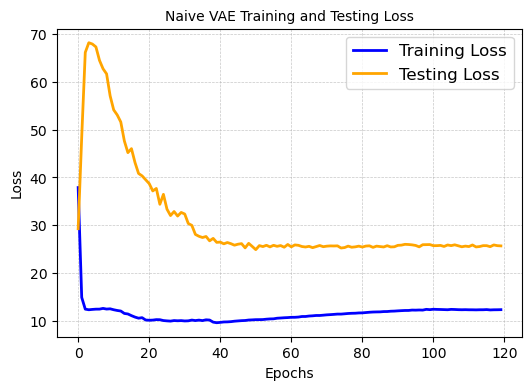

In [54]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss_list0, label='Training Loss', color='blue', linewidth=2)
plt.plot(test_loss_list0, label='Testing Loss', color='orange', linewidth=2)
plt.title('Naive VAE Training and Testing Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.show()

In [55]:
ten_angle_recons = []
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        # recon_batch, mu, logvar, log_det_jacobian = model(data)
        # test_loss += loss_function(recon_batch, data, mu, logvar, log_det_jacobian, 100).item()
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar, 100).item()        
        ten_angle_recons.extend(recon_batch.cpu().numpy())
test_loss /= len(test_loader)
print(test_loss)

25.460397720336914


In [56]:
import pandas as pd
ten_angle_recons = np.array(ten_angle_recons)
df = pd.DataFrame(ten_angle_recons, columns=[f'Var{i}' for i in range(10)])
correlation_matrix_recons = df.corr()

In [ ]:
torch.cuda.empty_cache()

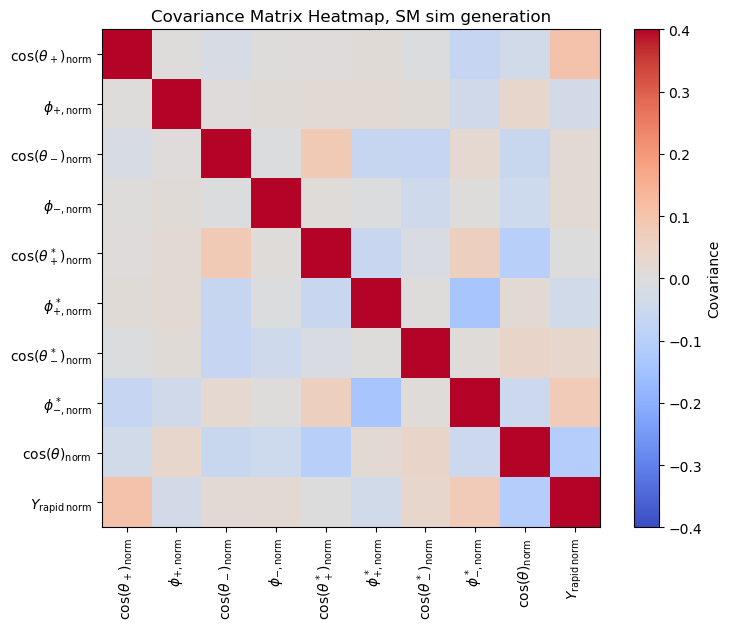

In [57]:
with torch.no_grad():
    # sample_uniform = torch.rand(55000, KZ).to(device)
    # low, high = -2, 2
    # sample_custom_uniform = low + (high - low) * torch.rand(55000, KZ).to(device)
    # ten_angle_sim = model.decode(sample_custom_uniform).cpu().numpy()
    extend_sim = []
    for i in range(55):
        sample = torch.randn(1000, KZ).to(device)
        extend_sim.append(model.decode(sample).cpu().numpy())
    ten_angle_sim = np.vstack(extend_sim)
import pandas as pd
df = pd.DataFrame(ten_angle_sim, columns=[f'Var{i}' for i in range(10)])
correlation_matrix_sim = df.corr()

labels = [
    r"$\cos(\theta_+)_\mathrm{norm}$",
    r"$\phi_{+,\mathrm{norm}}$",
    r"$\cos(\theta_-)_\mathrm{norm}$",
    r"$\phi_{-,\mathrm{norm}}$",
    r"$\cos(\theta^*_+)_\mathrm{norm}$",
    r"$\phi^*_{+,\mathrm{norm}}$",
    r"$\cos(\theta^*_-)_\mathrm{norm}$",
    r"$\phi^*_{-,\mathrm{norm}}$",
    r"$\cos(\theta)_\mathrm{norm}$",
    r"$Y_\mathrm{rapid \, norm}$"
]

plt.figure(figsize=(8, 6.4))
plt.imshow(correlation_matrix_sim, cmap='coolwarm', vmin=-0.4, vmax=0.4)
plt.colorbar(label='Covariance')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.title('Covariance Matrix Heatmap, SM sim generation')
plt.tight_layout()
plt.show()

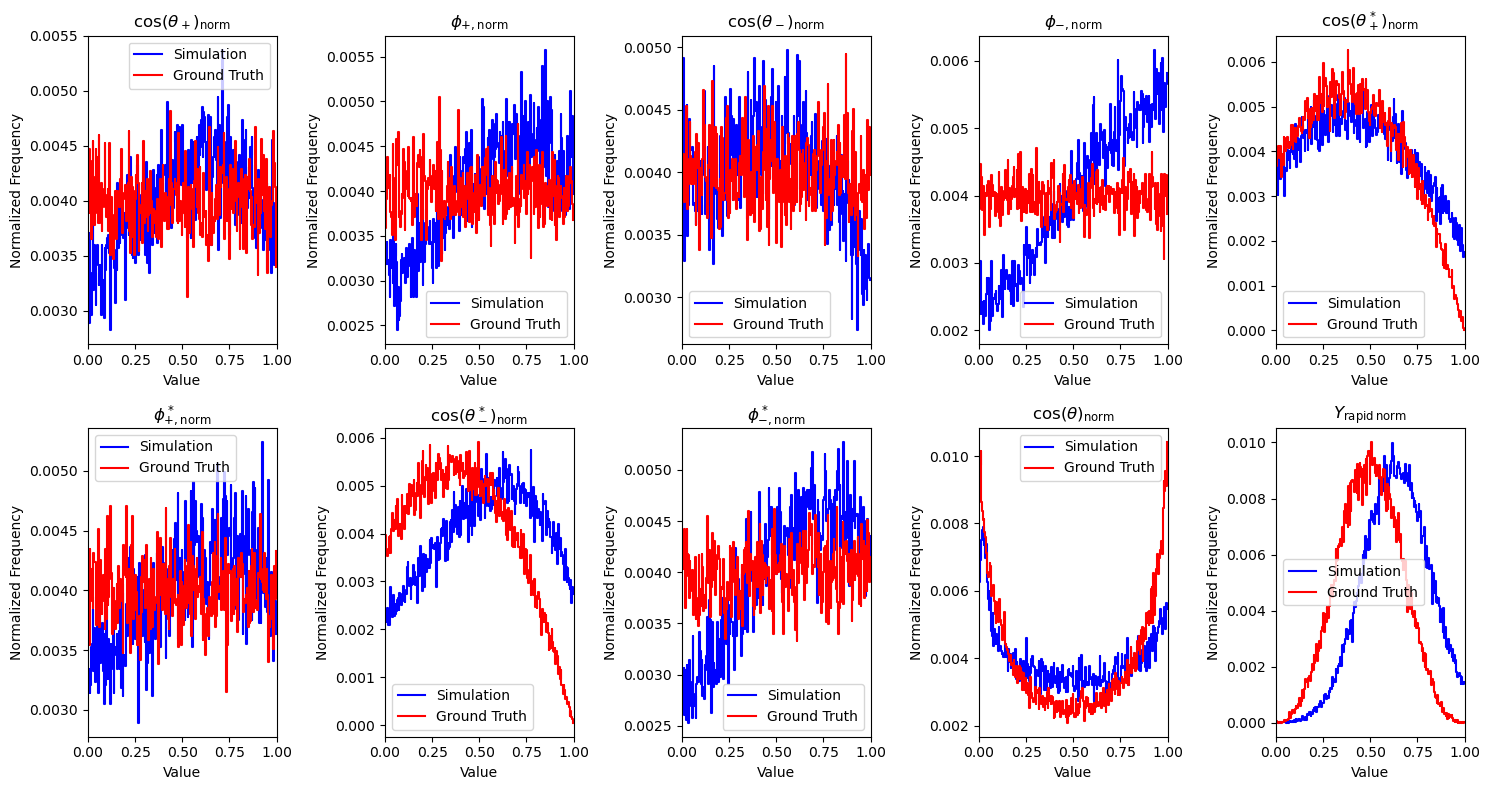

In [58]:
titles = [
    r"$\cos(\theta_+)_\mathrm{norm}$",
    r"$\phi_{+,\mathrm{norm}}$",
    r"$\cos(\theta_-)_\mathrm{norm}$",
    r"$\phi_{-,\mathrm{norm}}$",
    r"$\cos(\theta^*_+)_\mathrm{norm}$",
    r"$\phi^*_{+,\mathrm{norm}}$",
    r"$\cos(\theta^*_-)_\mathrm{norm}$",
    r"$\phi^*_{-,\mathrm{norm}}$",
    r"$\cos(\theta)_\mathrm{norm}$",
    r"$Y_\mathrm{rapid \, norm}$"
]


bins = 250
range_min, range_max = 0.0, 1.0

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns for 10 variables
axes = axes.flatten()  # Flatten to iterate easily

# Loop through columns and plot on respective subplot
for i in range(10):
    hist, bin_edges = np.histogram(ten_angle_sim[:, i], bins=bins, range=(range_min, range_max))
    hist = hist / sum(hist)  # Normalize the histogram
    axes[i].step(bin_edges[:-1], hist, where='post', linewidth=1.5, color='blue', label="Simulation")

    hist_truth, bin_edges_truth = np.histogram(ten_angle_SM[:, i], bins=bins, range=(range_min, range_max))
    hist_truth = hist_truth / sum(hist_truth)  # Normalize the histogram
    axes[i].step(bin_edges_truth[:-1], hist_truth, where='post', linewidth=1.5, color='red', label="Ground Truth")    
    
    axes[i].set_title(titles[i])
    axes[i].set_xlim(range_min, range_max)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Normalized Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [59]:
import umap
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results_sim = umap_model.fit_transform(ten_angle_sim)
umap_results_SM = umap_model.fit_transform(ten_angle_SM)

/home/ruixue/anaconda3/envs/root_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


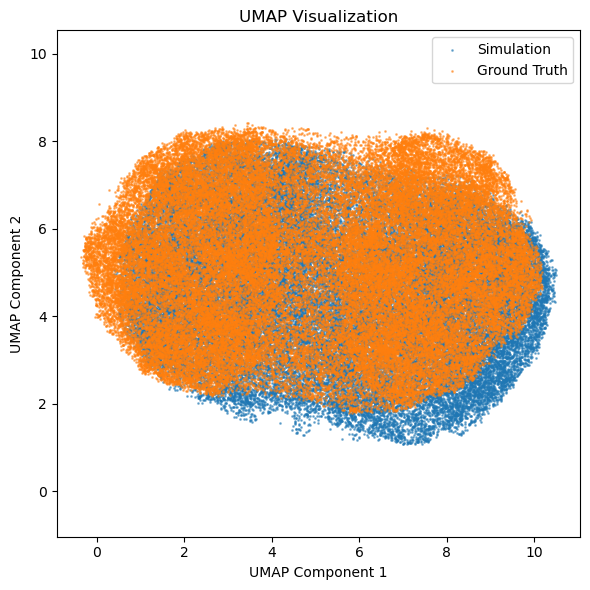

In [60]:
plt.figure(figsize=(6, 6))
plt.scatter(umap_results_sim[:, 0], umap_results_sim[:, 1], alpha=0.5, s=1, label="Simulation")
plt.scatter(umap_results_SM[:, 0], umap_results_SM[:, 1], alpha=0.5, s=1, label="Ground Truth")
plt.title("UMAP Visualization")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.axis('equal')
plt.tight_layout()
plt.legend()
plt.show()

In [61]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
import sys
import uproot
from torch.utils.data import DataLoader, TensorDataset, random_split

DIM6_file = uproot.open("Reweight_DIM6_cQQ.root")
DIM6_tree = DIM6_file["tree"]

cos_theta_plus = DIM6_tree["cos_theta_plus"].array(library="np")
phi_plus = DIM6_tree["phi_plus"].array(library="np")
cos_theta_minus = DIM6_tree["cos_theta_minus"].array(library="np")
phi_minus = DIM6_tree["phi_minus"].array(library="np")
cos_theta_star_plus = DIM6_tree["cos_theta_star_plus"].array(library="np")
phi_star_plus = DIM6_tree["phi_star_plus"].array(library="np")
cos_theta_star_minus = DIM6_tree["cos_theta_star_minus"].array(library="np")
phi_star_minus = DIM6_tree["phi_star_minus"].array(library="np")
cos_theta = DIM6_tree["cos_theta"].array(library="np")
Y_rapid = DIM6_tree["Y_rapid"].array(library="np")

NORM_cos_theta_plus = (cos_theta_plus+1)/2
NORM_phi_plus = (phi_plus+np.pi)/(2*np.pi)
NORM_cos_theta_minus = (cos_theta_minus+1)/2
NORM_phi_minus = (phi_minus+np.pi)/(2*np.pi)
NORM_cos_theta_star_plus = (cos_theta_star_plus+1)/2
NORM_phi_star_plus = (phi_star_plus+np.pi)/(2*np.pi)
NORM_cos_theta_star_minus = (cos_theta_star_minus+1)/2
NORM_phi_star_minus = (phi_star_minus+np.pi)/(2*np.pi)
NORM_cos_theta = (cos_theta+1)/2
NORM_Y_rapid = (Y_rapid+abs(min(Y_rapid)))/(max(Y_rapid)-min(Y_rapid))

ten_angle_SM = np.array([NORM_cos_theta_plus, NORM_phi_plus, NORM_cos_theta_minus, NORM_phi_minus, NORM_cos_theta_star_plus, NORM_phi_star_plus, NORM_cos_theta_star_minus, NORM_phi_star_minus, NORM_cos_theta, NORM_Y_rapid])
ten_angle_SM = ten_angle_SM.T
print(ten_angle_SM.shape)
sys.argv = [sys.argv[0]]

(55000, 10)


In [62]:
parser = argparse.ArgumentParser(description='VAE double top')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N', help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=120, metavar='N', help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N', help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda")  # Set to CPU

K1 = 2000
K2 = 2000
K3 = 2000
KZ = 200
# class PlanarFlow(nn.Module):
#     def __init__(self, dim):
#         super(PlanarFlow, self).__init__()
#         self.u = nn.Parameter(torch.randn(1,dim))
#         self.w = nn.Parameter(torch.randn(1 ,dim))
#         self.b = nn.Parameter(torch.randn(1))

#     def forward(self, z):
#         linear = z * self.w + self.b       # (batch, dim) * (1, dim) = (batch_size, dim)
#         tanh_linear = torch.tanh(linear)   # (batch, dim)
#         f_z = z + tanh_linear * self.u     # (batch, dim) * (1, dim) = (batch_size, dim)
        
#         psi = (1-tanh_linear**2) * self.w  # (batch, dim) * (1, dim) = (batch_size, dim)
#         det_jacobian = torch.mean(1 + self.u * psi, dim=1, keepdim=True)    # (batch, 1)
#         log_det_jacobian = torch.log(torch.abs(det_jacobian) + 1e-8)        # (batch, 1)
#         return f_z, log_det_jacobian

class RadialFlow(nn.Module):
    def __init__(self, dim):
        super(RadialFlow, self).__init__()

        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1, dim))
        self.d = dim

    def forward(self, x):
        def m(x):
            return F.softplus(x)
        def h(r):
            return 1. / (a + r)
        def h_prime(r):
            return -h(r)**2

        a = torch.exp(self.a)
        b = -a + m(self.b)
        r = (x - self.c).norm(dim=1, keepdim=True)
        tmp = b * h(r)
        x = x + tmp * (x - self.c)
        log_det = (self.d - 1) * torch.log(1. + tmp) + torch.log(1. + tmp + b * h_prime(r) * r)

        return x, log_det

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(10, K3)
        self.bn0 = nn.BatchNorm1d(K3)  # BatchNorm for fc0
        self.fc1 = nn.Linear(K3, K2)
        self.bn1 = nn.BatchNorm1d(K2)  # BatchNorm for fc1
        self.fc2 = nn.Linear(K2, K1)
        self.bn2 = nn.BatchNorm1d(K1)  # BatchNorm for fc2
        self.fc3 = nn.Linear(K1, K1)
        self.bn3 = nn.BatchNorm1d(K1)  # BatchNorm for fc3
        self.fcZ1 = nn.Linear(K1, KZ)  # Mean
        self.fcZ2 = nn.Linear(K1, KZ)  # Log-variance
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

        self.flow1 = RadialFlow(KZ)
        self.flow2 = RadialFlow(KZ)
        self.flow3 = RadialFlow(KZ)
        # self.flow1 = PlanarFlow(KZ)
        # self.flow2 = PlanarFlow(KZ)
        # self.flow3 = PlanarFlow(KZ)
        
        # Decoder
        self.fcZ = nn.Linear(KZ, K1)
        self.bnZ = nn.BatchNorm1d(K1)  # BatchNorm for fcZ
        self.fc4 = nn.Linear(K1, K1)
        self.bn4 = nn.BatchNorm1d(K1)  # BatchNorm for fc4
        self.fc5 = nn.Linear(K1, K2)
        self.bn5 = nn.BatchNorm1d(K2)  # BatchNorm for fc5
        self.fc6 = nn.Linear(K2, K3)
        self.bn6 = nn.BatchNorm1d(K3)  # BatchNorm for fc6
        self.fc7 = nn.Linear(K3, 10)
        
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        
    def encode(self, x):
        h1 = F.relu(self.bn0(self.fc0(x)))  # Apply BatchNorm after fc0
        h1 = self.dropout1(h1)
        h2 = F.relu(self.bn1(self.fc1(h1)))  # Apply BatchNorm after fc1
        h2 = self.dropout2(h2)
        h3 = F.relu(self.bn2(self.fc2(h2)))  # Apply BatchNorm after fc2
        h4 = F.relu(self.bn3(self.fc3(h3)))  # Apply BatchNorm after fc3
        return self.fcZ1(h4), self.fcZ2(h4)     

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h1 = F.relu(self.bnZ(self.fcZ(z)))  # Apply BatchNorm after fcZ
        h1 = self.dropout3(h1)
        h2 = F.relu(self.bn4(self.fc4(h1)))  # Apply BatchNorm after fc4
        h2 = self.dropout4(h2)
        h3 = F.relu(self.bn5(self.fc5(h2)))  # Apply BatchNorm after fc5
        h4 = F.relu(self.bn6(self.fc6(h3)))  # Apply BatchNorm after fc6
        return self.fc7(h4)    

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 10))
        z0 = self.reparameterize(mu, logvar)

        z1, log_det_jacobian1 = self.flow1(z0)
        z2, log_det_jacobian2 = self.flow2(z1)
        z3, log_det_jacobian3 = self.flow3(z2)
        log_det_jacobian = log_det_jacobian1 + log_det_jacobian2 + log_det_jacobian3
        return self.decode(z3), mu, logvar, log_det_jacobian
        # return self.decode(z1), mu, logvar, log_det_jacobian

def loss_function(recon_x, x, mu, logvar, log_det_jacobian, epoch):   
    L2 = torch.sum((recon_x - x) ** 2, dim=1, keepdim=True)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1, keepdim=True)
    kl_weight = min(1.0, epoch / 100)

    sampled_z = torch.randn(x.size()[0], KZ).to(device)
    sampled_recon = model.decode(sampled_z)
    sampled_loss = torch.sum((sampled_recon - x) ** 2, dim=1, keepdim=True)

    marginal_loss = 0
    for i in range(x.size(1)):
        real_feature = x[:,i]
        fake_feature = recon_x[:,i]
        marginal_loss += torch.mean( torch.abs(torch.sort(fake_feature)[0]-torch.sort(real_feature)[0]) )
    
    total_loss = torch.mean(L2*10 + KLD*kl_weight + sampled_loss - log_det_jacobian) + marginal_loss*10  #average over batch size!
    return total_loss

# Initialize model, optimizer, and scheduler
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) # adjust learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

ten_angle_SM_tensor = torch.tensor(ten_angle_SM, dtype=torch.float32)
total_events = len(ten_angle_SM)
train_size = int(0.9 * total_events)
test_size = total_events - train_size
train_data, test_data = random_split(ten_angle_SM_tensor, [train_size, test_size])

/home/ruixue/anaconda3/envs/root_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [63]:
train_loss_list = []
test_loss_list = []

test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)
for epoch in range(1, args.epochs + 1):     
    model.train()
    train_loss = 0
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, log_det_jacobian = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, log_det_jacobian, epoch)
        # recon_batch, mu, logvar = model(data)
        # loss = loss_function(recon_batch, data, mu, logvar, epoch)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar, log_det_jacobian = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar, log_det_jacobian, 100).item() 
    test_loss /= len(test_loader)  # Normalize by number of batches
    test_loss_list.append(test_loss)
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.6f}, Testing Loss: {test_loss:.6f}')

Epoch: 1, Training Loss: 45.649783, Testing Loss: 47.693502
Epoch: 2, Training Loss: 22.854098, Testing Loss: 84.858538
Epoch: 3, Training Loss: 20.007989, Testing Loss: 100.378703
Epoch: 4, Training Loss: 19.832566, Testing Loss: 99.084379
Epoch: 5, Training Loss: 20.015890, Testing Loss: 93.016050
Epoch: 6, Training Loss: 20.015464, Testing Loss: 88.949013
Epoch: 7, Training Loss: 20.028886, Testing Loss: 83.207245
Epoch: 8, Training Loss: 19.898520, Testing Loss: 79.551771
Epoch: 9, Training Loss: 19.917909, Testing Loss: 75.733223
Epoch: 10, Training Loss: 19.874176, Testing Loss: 70.093473
Epoch: 11, Training Loss: 19.641723, Testing Loss: 68.046730
Epoch: 12, Training Loss: 19.360266, Testing Loss: 65.866933
Epoch: 13, Training Loss: 18.906974, Testing Loss: 61.442776
Epoch: 14, Training Loss: 18.779992, Testing Loss: 57.781442
Epoch: 15, Training Loss: 18.342107, Testing Loss: 53.884350
Epoch: 16, Training Loss: 18.099614, Testing Loss: 54.803729
Epoch: 17, Training Loss: 17.677

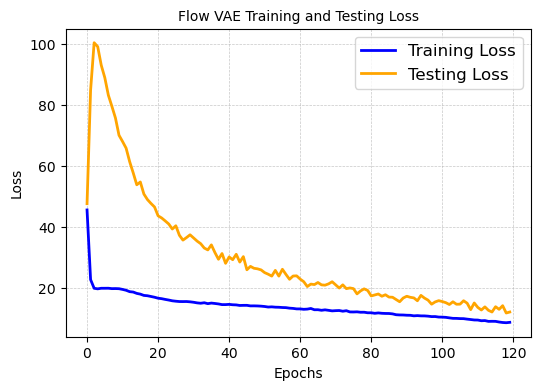

In [64]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss_list, label='Training Loss', color='blue', linewidth=2)
plt.plot(test_loss_list, label='Testing Loss', color='orange', linewidth=2)
plt.title('Flow VAE Training and Testing Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.show()

In [65]:
ten_angle_recons = []
model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        recon_batch, mu, logvar, log_det_jacobian = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar, log_det_jacobian, 100).item()
        # recon_batch, mu, logvar = model(data)
        # test_loss += loss_function(recon_batch, data, mu, logvar, 100).item()   
        ten_angle_recons.extend(recon_batch.cpu().numpy())
test_loss /= len(test_loader)
print(test_loss)

12.229445457458496


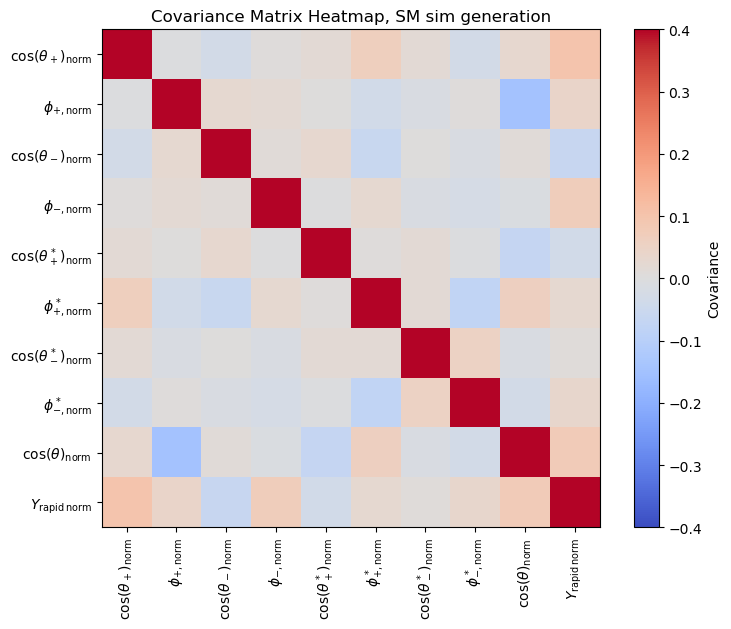

In [66]:
with torch.no_grad():
    # sample_uniform = torch.rand(55000, KZ).to(device)
    # low, high = -2, 2
    # sample_custom_uniform = low + (high - low) * torch.rand(55000, KZ).to(device)
    # ten_angle_sim = model.decode(sample_custom_uniform).cpu().numpy()
    sample = torch.randn(55000, KZ).to(device)
    ten_angle_sim = model.decode(sample).cpu().numpy()
import pandas as pd
df = pd.DataFrame(ten_angle_sim, columns=[f'Var{i}' for i in range(10)])
correlation_matrix_sim = df.corr()

labels = [
    r"$\cos(\theta_+)_\mathrm{norm}$",
    r"$\phi_{+,\mathrm{norm}}$",
    r"$\cos(\theta_-)_\mathrm{norm}$",
    r"$\phi_{-,\mathrm{norm}}$",
    r"$\cos(\theta^*_+)_\mathrm{norm}$",
    r"$\phi^*_{+,\mathrm{norm}}$",
    r"$\cos(\theta^*_-)_\mathrm{norm}$",
    r"$\phi^*_{-,\mathrm{norm}}$",
    r"$\cos(\theta)_\mathrm{norm}$",
    r"$Y_\mathrm{rapid \, norm}$"
]

plt.figure(figsize=(8, 6.4))
plt.imshow(correlation_matrix_sim, cmap='coolwarm', vmin=-0.4, vmax=0.4)
plt.colorbar(label='Covariance')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.title('Covariance Matrix Heatmap, SM sim generation')
plt.tight_layout()
plt.show()

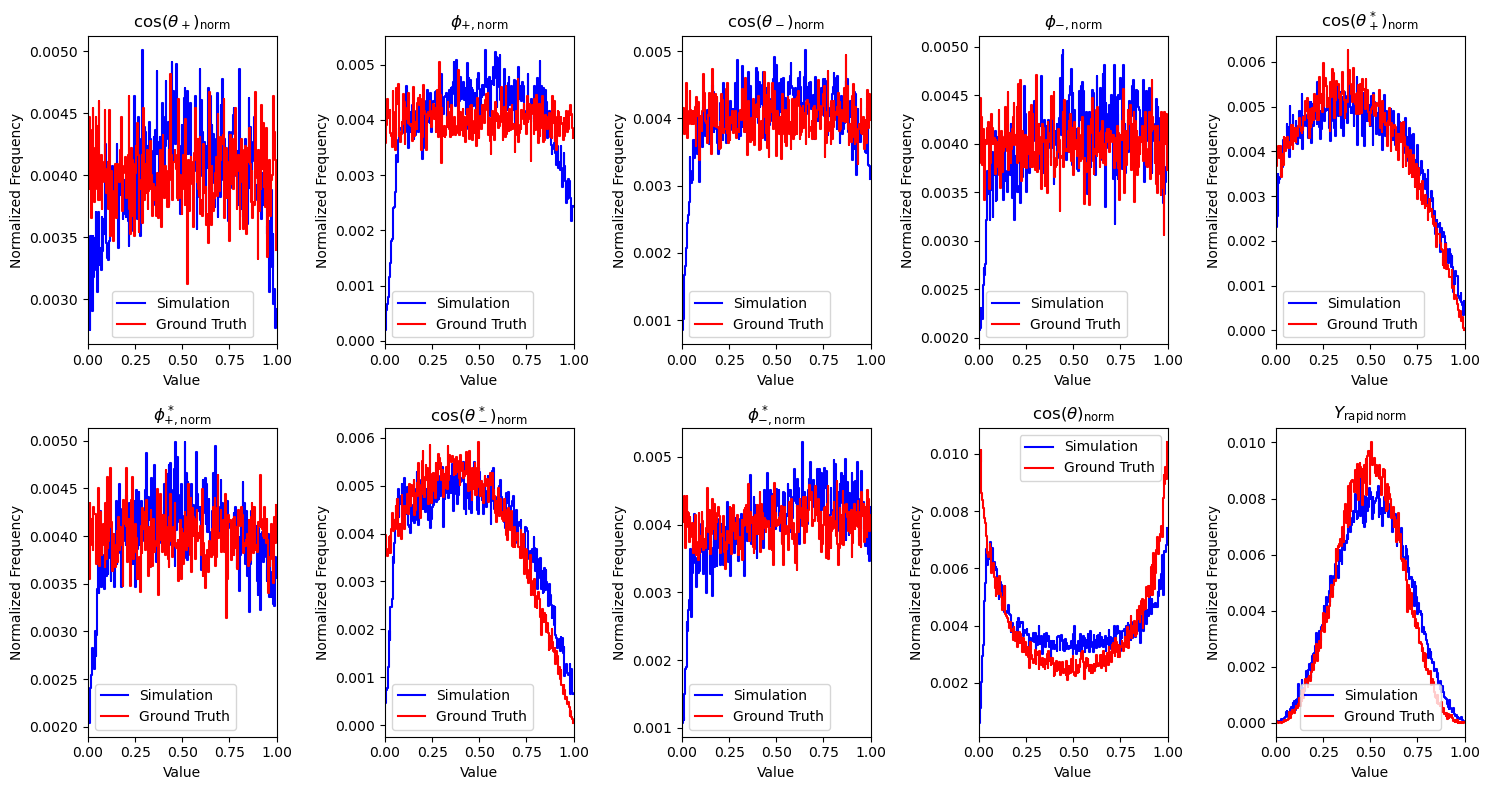

In [67]:
titles = [
    r"$\cos(\theta_+)_\mathrm{norm}$",
    r"$\phi_{+,\mathrm{norm}}$",
    r"$\cos(\theta_-)_\mathrm{norm}$",
    r"$\phi_{-,\mathrm{norm}}$",
    r"$\cos(\theta^*_+)_\mathrm{norm}$",
    r"$\phi^*_{+,\mathrm{norm}}$",
    r"$\cos(\theta^*_-)_\mathrm{norm}$",
    r"$\phi^*_{-,\mathrm{norm}}$",
    r"$\cos(\theta)_\mathrm{norm}$",
    r"$Y_\mathrm{rapid \, norm}$"
]


bins = 250
range_min, range_max = 0.0, 1.0

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns for 10 variables
axes = axes.flatten()  # Flatten to iterate easily

# Loop through columns and plot on respective subplot
for i in range(10):
    hist, bin_edges = np.histogram(ten_angle_sim[:, i], bins=bins, range=(range_min, range_max))
    hist = hist / sum(hist)  # Normalize the histogram
    axes[i].step(bin_edges[:-1], hist, where='post', linewidth=1.5, color='blue', label="Simulation")

    hist_truth, bin_edges_truth = np.histogram(ten_angle_SM[:, i], bins=bins, range=(range_min, range_max))
    hist_truth = hist_truth / sum(hist_truth)  # Normalize the histogram
    axes[i].step(bin_edges_truth[:-1], hist_truth, where='post', linewidth=1.5, color='red', label="Ground Truth")    
    
    axes[i].set_title(titles[i])
    axes[i].set_xlim(range_min, range_max)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Normalized Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [68]:
import umap
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results_sim = umap_model.fit_transform(ten_angle_sim)
umap_results_SM = umap_model.fit_transform(ten_angle_SM)

/home/ruixue/anaconda3/envs/root_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


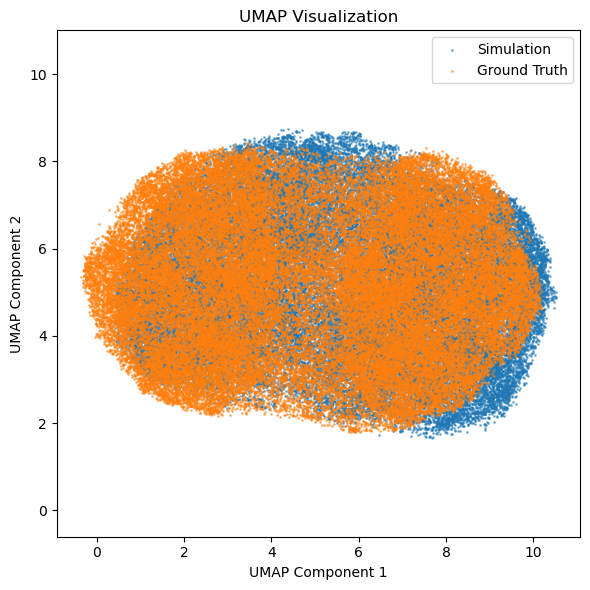

In [70]:
plt.figure(figsize=(6, 6))
plt.scatter(umap_results_sim[:, 0], umap_results_sim[:, 1], alpha=0.5, s=1, label="Simulation")
plt.scatter(umap_results_SM[:, 0], umap_results_SM[:, 1], alpha=0.5, s=1, label="Ground Truth")
plt.title("UMAP Visualization")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.axis('equal')
plt.tight_layout()
plt.legend()
plt.show()

In [29]:
model.eval()
latent_representations = []
latent_flow = []
with torch.no_grad():
    for data in test_loader:  # Assume a labeled dataset
        data = data.to(device)
        mu, logvar = model.encode(data)  # Extract mean and log variance
        z = model.reparameterize(mu, logvar)  # Sample latent variables
        latent_representations.extend(z.cpu().numpy())

        z1, _ = model.flow1(z)
        z2, _ = model.flow2(z1)
        z3, _ = model.flow3(z2)
        latent_flow.extend(z3.cpu().numpy())
    
latent_representations = np.array(latent_representations)
latent_flow = np.array(latent_flow)
latent_representations.shape

(5500, 200)

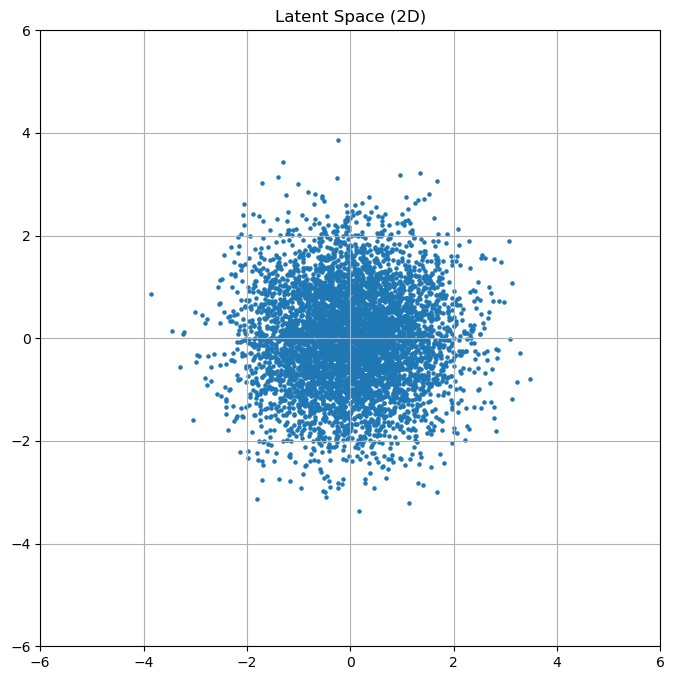

In [30]:
plt.figure(figsize=(8, 8))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], s=5)
plt.title("Latent Space (2D)")
plt.grid(True)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.show()

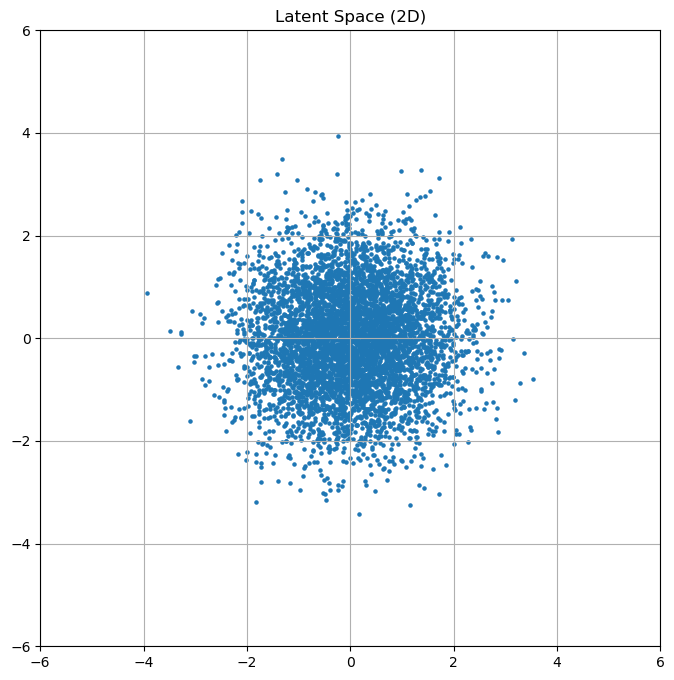

In [31]:
plt.figure(figsize=(8, 8))
plt.scatter(latent_flow[:, 0], latent_flow[:, 1], s=5)
plt.title("Latent Space (2D)")
plt.grid(True)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.show()

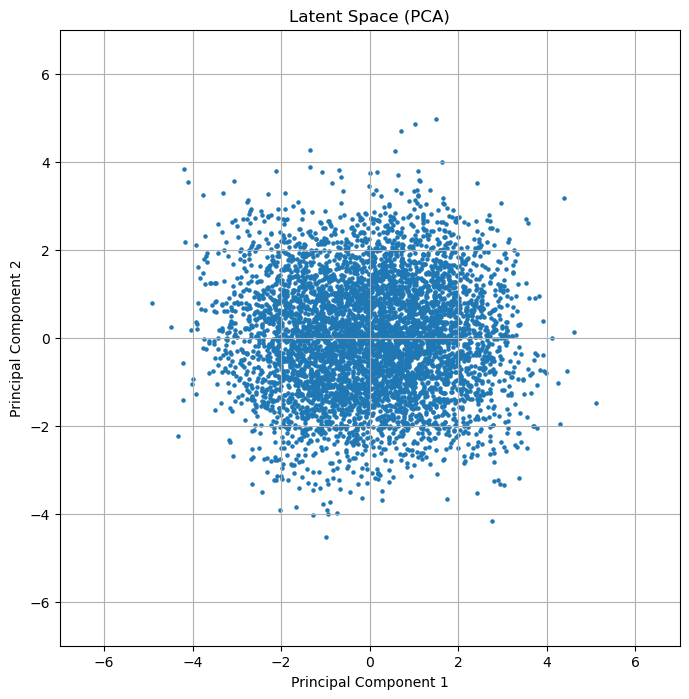

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z_2d1 = pca.fit_transform(latent_representations)

plt.figure(figsize=(8, 8))
plt.scatter(z_2d1[:, 0], z_2d1[:, 1], s=5)
plt.title("Latent Space (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.xlim(-7,7)
plt.ylim(-7,7)
plt.show()

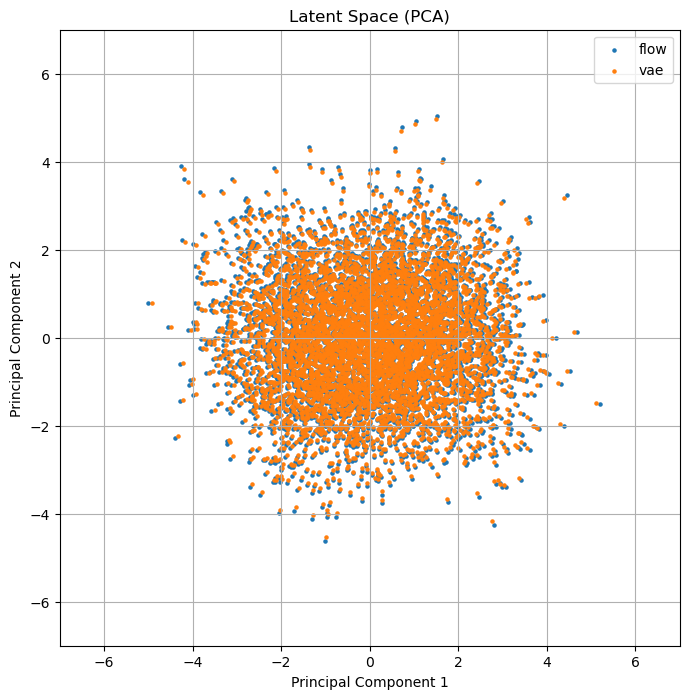

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z_2d = pca.fit_transform(latent_flow)

plt.figure(figsize=(8, 8))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=5, label="flow")
plt.scatter(z_2d1[:, 0], z_2d1[:, 1], s=5, label="vae")
plt.title("Latent Space (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.xlim(-7,7)
plt.ylim(-7,7)
plt.legend()
plt.show()

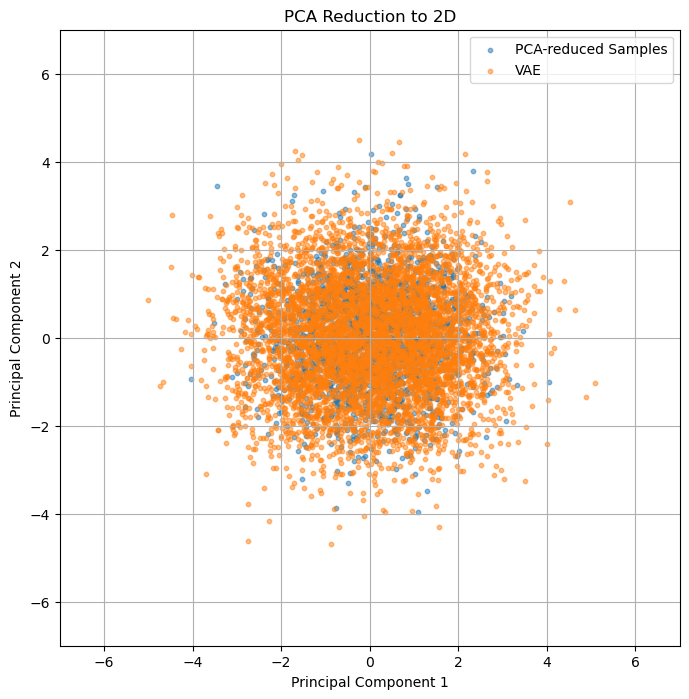

In [27]:
num_samples = 2000
dim = 50
samples = np.random.randn(num_samples, dim)  # Random samples from a standard normal distribution

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(samples)

# Plot the 2D PCA result
plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, s=10, label="PCA-reduced Samples")
plt.scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.5, s=10, label="VAE")
plt.title("PCA Reduction to 2D")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.xlim(-7,7)
plt.ylim(-7,7)
plt.show()